In [1]:
# Set Kaggle API - Username / Key
import os
os.environ['KAGGLE_USERNAME'] = "franconicolsmerenda"
os.environ['KAGGLE_KEY'] = "edcd91fb1521ad3ee181a8b093795eab"
os.environ['DATASET_FOLDER'] = "/home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets"
os.environ['ART_STYLE'] = "renaissance"

# DATASET Folders
os.environ['TRAIN_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/train"
os.environ['TEST_DATASET_ART_STYLE'] = f"{os.environ['DATASET_FOLDER']}/Real_AI_SD_LD_Dataset/test"

# Data to be consumed by the model!
os.environ['TOP_DIR']=f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}"
os.environ['TRAIN_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/train"
os.environ['VALID_ART_STYLE_DATA'] = f"{os.environ['DATASET_FOLDER']}/{os.environ['ART_STYLE']}/valid"

In [2]:
# Download Datasets if Needed
import os

# Define the folder path
folder_path = f"{os.environ['DATASET_FOLDER']}"

# Check if the folder exists
if not os.path.exists(f"{folder_path}/Real_AI_SD_LD_Dataset"):
    # Install kaggle package
    !pip install -q kaggle
    # Download the dataset from Kaggle
    !kaggle datasets download -d ravidussilva/real-ai-art -p $folder_path --unzip
else:
    print("Folder already exists.")

Folder already exists.


In [3]:
# Set Art Style Dataset

# 1. Make clean data
!rm -rf $TRAIN_ART_STYLE_DATA
!rm -rf $VALID_ART_STYLE_DATA

# 2. Create folders of the current art style training/validation data
!mkdir -p $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $TRAIN_ART_STYLE_DATA/$ART_STYLE

!mkdir -p $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!mkdir -p $VALID_ART_STYLE_DATA/$ART_STYLE

# 3. Load with data from DATASET
!cp -r $TRAIN_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TRAIN_DATASET_ART_STYLE/$ART_STYLE/*.jpg $TRAIN_ART_STYLE_DATA/$ART_STYLE

!cp -r $TEST_DATASET_ART_STYLE/AI_LD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/AI_SD_$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/AI_GENERATED_$ART_STYLE
!cp -r $TEST_DATASET_ART_STYLE/$ART_STYLE/*.jpg $VALID_ART_STYLE_DATA/$ART_STYLE

In [4]:
#Import Dependencies
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Rescaling, Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd

2024-07-17 13:34:41.272233: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-07-17 13:34:41.743319: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [5]:
# Define paths to training and validation data
train_data_dir = os.environ['TRAIN_ART_STYLE_DATA']
valid_data_dir = os.environ['VALID_ART_STYLE_DATA']

# Define constants
IMG_WIDTH, IMG_HEIGHT = 224, 224
BATCH_SIZE = 64
NUM_EPOCHS = 30

In [6]:
#Main directory where datasets are stored
top_dir = os.environ['TOP_DIR']

# Define the training paths
train_dir = os.path.join(top_dir, 'train')

# List all directories in the train directory
all_directories = os.listdir(train_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
train_human = []
train_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        train_human.append(os.path.join(train_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        train_ai.append(os.path.join(train_dir, directory))

# Print the lists of directories
print("Train directories containing human-drawn images:")
for i, directory in enumerate(train_human):
    print(f"{i}. {directory}")

print("\nTrain directories containing AI-generated images:")
for i, directory in enumerate(train_ai):
    print(f"{i}. {directory}")

Train directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/renaissance/train/renaissance

Train directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/renaissance/train/AI_GENERATED_renaissance


In [7]:
# Define the test paths
test_dir = os.path.join(top_dir, 'valid')

# List all directories in the test directory
all_directories = os.listdir(test_dir)

# Initialize lists to store directories for human-drawn and AI-generated images
test_human = []
test_ai = []

# Loop through all directories
for directory in all_directories:
    # Check if the directory represents human-drawn images
    if not directory.startswith('AI_'):
        test_human.append(os.path.join(test_dir, directory))
    # Check if the directory represents AI-generated images
    else:
        test_ai.append(os.path.join(test_dir, directory))

# Print the lists of directories
print("Test directories containing human-drawn images:")
for i, directory in enumerate(test_human):
    print(f"{i}. {directory}")

print("\nTest directories containing AI-generated images:")
for i, directory in enumerate(test_ai):
    print(f"{i}. {directory}")

Test directories containing human-drawn images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/renaissance/valid/renaissance

Test directories containing AI-generated images:
0. /home/millenium-falcon/SoftwareProjects/ai-art-casa/notebooks/.datasets/renaissance/valid/AI_GENERATED_renaissance


In [8]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for train_data with the columns filepath and label
train_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under train_human as "human"
for directory in train_human:
    for file in os.listdir(directory):
        #creating value to store in filepath column
        filepath = os.path.join(directory, file)
        #append value into the column filepath
        filepaths.append(filepath)
        #adding classification 'human' to value
        labels.append("human")

# Label files under train_ai as "AI"
for directory in train_ai:
    for file in os.listdir(directory):
        #creating value to store in filepath column
        filepath = os.path.join(directory, file)
        #append value into the column filepath
        filepaths.append(filepath)
        #adding classification 'AI' to value
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with train_data
train_data = pd.concat([train_data, data], ignore_index=True)

In [9]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

                                            filepath  label
0  /home/millenium-falcon/SoftwareProjects/ai-art...  human
1  /home/millenium-falcon/SoftwareProjects/ai-art...  human
2  /home/millenium-falcon/SoftwareProjects/ai-art...  human
3  /home/millenium-falcon/SoftwareProjects/ai-art...  human
4  /home/millenium-falcon/SoftwareProjects/ai-art...  human


In [10]:
# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("Number of files under each label:")
print(file_counts)

Number of files under each label:
label
AI       10476
human     5000
Name: count, dtype: int64


In [11]:
#BALANCE OFF

# Set the random seed for reproducibility
random_seed = 123  # Change this to your desired seed number
np.random.seed(random_seed)

# Number of rows to drop for the 'AI' label
num_to_drop = int(file_counts[0]/2) if file_counts[0]> file_counts[1] else 0

# Get the indices of rows with the 'AI' label
ai_indices = train_data[train_data['label'] == 'AI'].index

# Randomly select indices to drop using the specified seed
indices_to_drop = np.random.choice(ai_indices, num_to_drop, replace=False)

# Drop the selected rows from the DataFrame
train_data = train_data.drop(indices_to_drop)

# Reset the index of the DataFrame after dropping rows
train_data.reset_index(drop=True, inplace=True)

/tmp/ipykernel_291770/794083406.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  num_to_drop = int(file_counts[0]/2) if file_counts[0]> file_counts[1] else 0


In [11]:
# Display the first few rows of the train_data DataFrame
print(train_data.head())

# Count the number of files under each label
file_counts = train_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /home/millenium-falcon/SoftwareProjects/ai-art...  human
1  /home/millenium-falcon/SoftwareProjects/ai-art...  human
2  /home/millenium-falcon/SoftwareProjects/ai-art...  human
3  /home/millenium-falcon/SoftwareProjects/ai-art...  human
4  /home/millenium-falcon/SoftwareProjects/ai-art...  human

Number of files under each label:
label
AI       10476
human     5000
Name: count, dtype: int64


In [12]:
# Initialize lists to store file paths and labels
filepaths = []
labels = []

# Initialize an empty DataFrame for test_data
test_data = pd.DataFrame(columns=['filepath', 'label'])

# Label files under test_human as "human"
for directory in test_human:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("human")

# Label files under test_ai as "AI"
for directory in test_ai:
    for file in os.listdir(directory):
        filepath = os.path.join(directory, file)
        filepaths.append(filepath)
        labels.append("AI")

# Create a DataFrame with file paths and labels
data = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Concatenate data with test_data
test_data = pd.concat([test_data, data], ignore_index=True)

In [13]:
# Display the first few rows of the test_data DataFrame
print(test_data.head())

# Count the number of files under each label
file_counts = test_data['label'].value_counts()

# Print the counts
print("\nNumber of files under each label:")
print(file_counts)

                                            filepath  label
0  /home/millenium-falcon/SoftwareProjects/ai-art...  human
1  /home/millenium-falcon/SoftwareProjects/ai-art...  human
2  /home/millenium-falcon/SoftwareProjects/ai-art...  human
3  /home/millenium-falcon/SoftwareProjects/ai-art...  human
4  /home/millenium-falcon/SoftwareProjects/ai-art...  human

Number of files under each label:
label
AI       2000
human    1000
Name: count, dtype: int64


In [14]:
#Created training set with data augmentation
training_generator = ImageDataGenerator(rescale=1./255,   # to normalize pixel value
                                        rotation_range=7, # it will apply rotations to the image
                                        horizontal_flip=True, # it will flip image horizontally
                                       # zoom_range=0.2  # it will increase and decrease zoom by 0.2x
                                       )
train_dataset = training_generator.flow_from_dataframe(
    dataframe=train_data,
    x_col='filepath',  # Column containing file paths
    y_col='label',     # Column containing labels
    target_size=(IMG_WIDTH, IMG_HEIGHT),
    batch_size=64,
    class_mode='binary',  
    shuffle=True
)

Found 15476 validated image filenames belonging to 2 classes.


In [15]:
train_dataset.class_indices

{'AI': 0, 'human': 1}

In [16]:
#Created validation set
val_generator = ImageDataGenerator(rescale=1./255,rotation_range=7, # it will apply rotations to the image
                                        horizontal_flip=True)
val_dataset = val_generator.flow_from_dataframe(  dataframe=test_data,
                                                    x_col='filepath',  # Column containing file paths
                                                    y_col='label',     # Column containing labels
                                                    target_size = (IMG_WIDTH, IMG_HEIGHT),
                                                    batch_size = 1,    # 1 image at a time to evaluate the NN
                                                    class_mode = 'binary',
                                                    shuffle = False)   # to associate the prediction with expected output

val_dataset.class_indices

Found 3000 validated image filenames belonging to 2 classes.


{'AI': 0, 'human': 1}

In [17]:
#from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomZoom

#Created network using VGG16 and transfer learning from 'ImageNet'
network= VGG19(weights='imagenet', include_top=False, input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))

for layer in network.layers:
    layer.trainable=False
##network.trainable = False # Transfer Learning - Freezing weights of base model
network.summary()

# Added layers to the base model created by VGG16
flatten_layer = Flatten()
dense_layer_1 = Dense(256, activation='relu') ##Dense(64, activation='relu')
dropout_1= Dropout(0.5) ##Dropout(0.2)
##dense_layer_2 = Dense(32, activation='relu')
predictions = Dense(units = 1, activation='sigmoid')

model = Sequential([
   network,
   flatten_layer,
   dense_layer_1,
##   dense_layer_2,
    dropout_1,
   predictions
],)


2024-07-17 13:37:50.894348: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 13:37:50.934740: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-17 13:37:50.934934: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Model: "vgg19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv4 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv4 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv4 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 20,024,384 (76.39 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 20,024,384 (76.39 MB)

In [18]:
# Compile the model
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=5,  restore_best_weights=True)

In [19]:

#TRAINING MODEL
history = model.fit(train_dataset, epochs=NUM_EPOCHS, validation_data=val_dataset, callbacks=[es])

Epoch 1/30


/home/millenium-falcon/.local/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1721234280.725243  342067 service.cc:145] XLA service 0x7336b000eb40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1721234280.725269  342067 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3070 Ti, Compute Capability 8.6
2024-07-17 13:38:00.746438: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-17 13:38:00.921052: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
2024

  2/242 ━━━━━━━━━━━━━━━━━━━━ 23s 99ms/step - accuracy: 0.5078 - loss: 2.7601 

I0000 00:00:1721234288.753734  342067 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


187/242 ━━━━━━━━━━━━━━━━━━━━ 20s 370ms/step - accuracy: 0.8131 - loss: 0.6914

2024-07-17 13:39:19.655769: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.46GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


242/242 ━━━━━━━━━━━━━━━━━━━━ 122s 459ms/step - accuracy: 0.8294 - loss: 0.6082 - val_accuracy: 0.9243 - val_loss: 0.1847
Epoch 2/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 431ms/step - accuracy: 0.9318 - loss: 0.1757 - val_accuracy: 0.9510 - val_loss: 0.1250
Epoch 3/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 431ms/step - accuracy: 0.9461 - loss: 0.1437 - val_accuracy: 0.9357 - val_loss: 0.1797
Epoch 4/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 432ms/step - accuracy: 0.9513 - loss: 0.1263 - val_accuracy: 0.9560 - val_loss: 0.1108
Epoch 5/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 108s 433ms/step - accuracy: 0.9521 - loss: 0.1217 - val_accuracy: 0.9407 - val_loss: 0.1414
Epoch 6/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 430ms/step - accuracy: 0.9597 - loss: 0.1062 - val_accuracy: 0.9623 - val_loss: 0.0947
Epoch 7/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 433ms/step - accuracy: 0.9650 - loss: 0.1032 - val_accuracy: 0.9500 - val_loss: 0.1237
Epoch 8/30
242/242 ━━━━━━━━━━━━━━━━━━━━ 107s 431ms/step - accuracy: 0.9623 - loss: 0.10

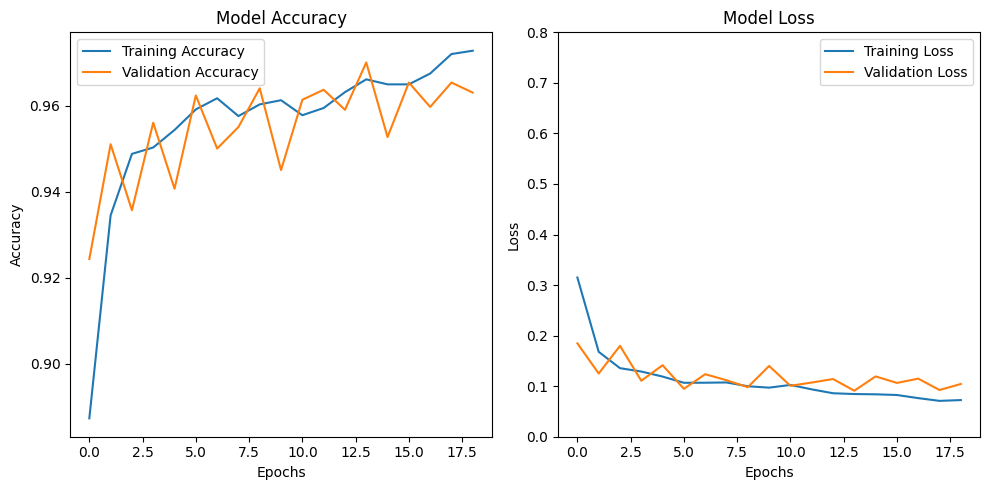

In [20]:
# Accuracy vs Loss

# Plotting accuracy
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 0.8)  # Adjust the upper limit of the y-axis
plt.title('Model Loss')
plt.legend()

plt.tight_layout()
plt.show()